## Coursework Part 2

### Muaaz Bin Sarfaraz
### Chadi El Hajj

Msc Data Science

In [1]:
# try this in case of "sc undefined" errors, also works outside the Notebook environment
from pyspark import SparkContext

try: 
    sc.stop()
    print('Stopped existing SparkContext')
except Exception as e: 
    # print(e) # for debugging
    pass

try: 
    sc = SparkContext(appName='Coursework part 2')
    print('Created new SparkContext')
except Exception as e: 
    print(e)
# for testing
print('Proterties of sc: ',list(sc.getConf().getAll())) 
# we need a SparkSession to create DataFrames
spark = SparkSession.builder.getOrCreate()

Stopped existing SparkContext
Created new SparkContext
Proterties of sc:  [('spark.eventLog.enabled', 'true'), ('spark.executor.logs.rolling.time.interval', 'daily'), ('spark.executor.extraJavaOptions', '-Xss8192k'), ('spark.master', 'spark://10.207.1.85:7077'), ('spark.driver.port', '42943'), ('spark.executor.id', 'driver'), ('spark.executor.logs.rolling.strategy', 'time'), ('spark.app.id', 'app-20170423141527-2443'), ('spark.driver.memory', '1g'), ('spark.app.name', 'Coursework part 2'), ('spark.executor.memory', '1g'), ('spark.rdd.compress', 'True'), ('spark.driver.host', '10.207.1.85'), ('spark.serializer.objectStreamReset', '100'), ('spark.cores.max', '2'), ('spark.submit.deployMode', 'client'), ('spark.driver.extraJavaOptions', '-Xss8192k'), ('spark.eventLog.dir', '/data/sparklog')]


### Dataset
##### The dataset chosen for this task is LingSpam dataset. There are four directories in this dataset and each subdirectory contain 10 parts. Each part consists of files both spam and ham messages. We train the data on 9 parts and hold out one for testing. We are only using the bare subdirectory for this task. This dataset qualifies as a big data and would help us in building the relevant skills in text analysis. Working on this raw dataset allow us to perform many preprocessing steps such as tokenization, stop word remover and hashing etc.

### Task
##### The task we choose to perform on this dataset is the classification of spam or ham using logistic regression (LR). LR is statistical model used to predict the probability of occurance e.g event. It works by fitting the data into a logit function and uses a threshold of 0.5 to predict the likelihood of whether the event happens or in our case whether the file is spam or ham. If the probability is higher than 0.5 than it maps it to 1 or zero otherwise. Therefore, it is appropriate to use this method for this task as our results are binary outcome spam or ham. 

### Preprocessing steps
##### Tokenizer - In order to break the text files into (words) tokens to be added to the index
##### stop word removal- to remove the stop words and punctuation from the files (to improve accuracy)
##### Hashing- It is a transformer which takes sets of terms and converts those sets into fixed-length feature vectors for dimension reduction.


### Dataset reference:
Ion Androutsopoulos http://www.aueb.gr/users/ion/
Ling-Spam corpus last updated: July 17, 2000
This file (readme.txt) last updated: July 30, 2003.

In [1]:
import re 

#function for changing file into a spark dataframe
def read_rows_DF( argDir ):  
    ft_RDD = sc.wholeTextFiles(argDir) # task a) read the files 
    count=ft_RDD.count()
    print('Read {} files from directory {}'.format(ft_RDD.count(),argDir)) #count the files in directory
    spm_t_RDD = ft_RDD.map(lambda ft: (ft[1], 0.0 if re.search('spmsg',ft[0]) is None else 1.0)) #labelling as 0 if spam else 1
    rows_DF = spark.createDataFrame(spm_t_RDD, schema=['text','label']) # create a DataFrame
    return rows_DF,count 

Read 291 files from directory hdfs://saltdean.nsqdc.city.ac.uk/data/spam/bare/part10
Read 289 files from directory hdfs://saltdean.nsqdc.city.ac.uk/data/spam/bare/part[1]
+--------------------+-----+
|                text|label|
+--------------------+-----+
|Subject: sound pa...|  0.0|
|Subject: atelier ...|  0.0|
+--------------------+-----+
only showing top 2 rows

Done


## Setting up a Pipeline

##### We set the pipeline with 4 stages. 
##### Stage 1: tokenizer to break down the file into words
##### Stage 2: stop word remover 
##### Stage 3: hashing transforms the words vectors into a reduced hash vector. This helps if the vocabulary/bag of words is huge as it speeds up the process wich in turn reduced the computational time. 
##### Stage 4: logistic regression as a machine leanring algorithm to classify the files.

In [2]:
import time # for calcuating time taken for processes
from pyspark.ml import Pipeline #using pipeline to manage tasks
from pyspark.ml.classification import LogisticRegression # Machine Learning Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Binary task thus binary evaluation
from pyspark.ml.feature import HashingTF,StopWordsRemover, Tokenizer
from pyspark.ml.tuning import ParamGridBuilder # Grid serach parameters
from pyspark.ml.tuning import TrainValidationSplit # splitting training set further into training and validation sets

testing = spam_test_DF # test dataframe

# Configure an ML pipeline, which consists of four stages: tokenizer, stop word remover, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words") #breaks text into words
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered") # removes stopwords
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features") # transforms to term freq
lr = LogisticRegression(maxIter=10) #log likelihood iteration is set to 10

pipeline_1 = Pipeline(stages=[tokenizer, remover,hashingTF, lr]) # setup a pipeline with preprocessing steps and Logistic Regression


# We can now treat the Pipeline as an Estimator, wrapping it in a Train-Validator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A TrainValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 3 values for lr.regParam,
# With 3 values for lr.maxIter,
# this grid will have 3 x 3 x 2 = 18 parameter settings for TrainValidator to choose from.
pipe_eval=BinaryClassificationEvaluator() #binary class evaluator since we only have two output classes either SPAM and HAM


#### pipeline evaluation

In [21]:
testDirPattern = 'hdfs://saltdean/data/spam/bare/part10' # creating test directory
PipeTrainDir = 'hdfs://saltdean/data/spam/bare/part[1-{}]' # create train directory format

for i in range(1,10):# Run Train-validation
    PipeTrainPaths = PipeTrainDir.format(i) # create a path
    PipeTrain,count1 = read_rows_DF(PipeTrainPaths)
    print('Start Training')
    PipeModel = pipeline_1.fit(PipeTrain) # training pipeline model 
    print('Finish Training')

    PipePrediction = PipeModel.transform(PipeTrain) # make prediction on the training model
    PipeTrain_acc=pipe_eval.evaluate(PipePrediction) # get training accuracy 
    print("training accuracy: ", PipeTrain_acc) 

    pipeTest,count2 = read_rows_DF(testDirPattern)
    PipePredictionTest = PipeModel.transform(pipeTest) # make predication using the test dataset on the trained model 
    PipeTest_acc=pipe_eval.evaluate(PipePredictionTest) # get test accuracy of the predication 
    print("testing accuracy: ", PipeTest_acc)

Read 289 files from directory hdfs://saltdean/data/spam/bare/part[1-1]
Start Training
Finish Training
training accuracy:  1.0
Read 291 files from directory hdfs://saltdean/data/spam/bare/part10
testing accuracy:  0.9489795918367345
Read 578 files from directory hdfs://saltdean/data/spam/bare/part[1-2]
Start Training
Finish Training
training accuracy:  1.0
Read 291 files from directory hdfs://saltdean/data/spam/bare/part10
testing accuracy:  0.9938438185191432
Read 867 files from directory hdfs://saltdean/data/spam/bare/part[1-3]
Start Training
Finish Training
training accuracy:  1.0
Read 291 files from directory hdfs://saltdean/data/spam/bare/part10
testing accuracy:  0.9973857311519648
Read 1156 files from directory hdfs://saltdean/data/spam/bare/part[1-4]
Start Training
Finish Training
training accuracy:  1.0
Read 291 files from directory hdfs://saltdean/data/spam/bare/part10
testing accuracy:  0.9973857311519648
Read 1446 files from directory hdfs://saltdean/data/spam/bare/part[1-5]


Testing the pipeline was successful with no errors. 
One can observe here that with no grid search and default parameters a high accuracy on test set is achieved by training the model with 578 files. However a plateau in the test accuracy is reached soon and increasing the training set further gave minor changes in accuracy or no changes at all.

#### ParamGrid and train validation split

In [ ]:
# initialise arrays for plotting
training_time=[]
testing_time=[]
file_count=[]
training_accuracy=[]
testing_accuracy=[]


bc_eval=BinaryClassificationEvaluator() #binary class evaluator since we only have two output classes either SPAM and HAM

#trying different hashvectors [10, 100, 200] #experimenting various regularization Parameter in LR [0, 0.1]
#experimenting various iterations of log Likelihood in LR [20,40]
paramGrid_1 = ParamGridBuilder().addGrid(hashingTF.numFeatures, [10, 100, 200]).addGrid(lr.regParam, [0, 0.1]) \
            .addGrid(lr.maxIter, [20,40]) \
            .build()
    
#Grid search is to experiment with different set of parameters to chose the best model. Experimenting with hash vector size since 
#the bag of words considered in the vector affect accuracy results

# split the data into 80% training and 20% testing
tvs = TrainValidationSplit(estimator=pipeline_1,
                           estimatorParamMaps=paramGrid_1,
                           evaluator=bc_eval,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

## Varying training set size

In [5]:
# Expected running time for this cell is 40 minutes (we reduced the train datasets to only 4 parts instead of 9 sets
# since it takes many hours to run on all parts with the grid search 
# Trying different training set sizes with ParamGrid and TrainValidation 

# prepare the part directories and the path
dirPattern = 'hdfs://saltdean/data/spam/bare/part[1-{}]' # the {} can be filled by 'dirPattern.format(i)' 
testing,count2 = spam_test_DF
print('EXPERIMENT: Testing different training set sizes with the best Model selected by ParamBuilder')
print('Path = {},'.format(dirPattern)) # using format to make sure we record the parameters of the experiment
#<<< make the test set, it will be constant for this experiment
#<<< loop over i the number of parts for training (1-5)
for i in range(1,5):# Run Train-validation and record the time taken to train
    trainPaths = dirPattern.format(i) # create a path
    print(trainPaths) #for testing
    training,count = read_rows_DF(trainPaths)
    file_count.append(count)
    print('Start Training')
    start1=time.clock() # start timer to record computational time taken to train
    Model = tvs.fit(training) # training the model 
    end1=time.clock() 
    training_time.append(end1-start1) # get time taken to train
    print('Finish Training')

    # Make predictions on training documents and save the time taken to for the prediction
    start2=time.clock() # start time recording
    prediction = Model.transform(training) # make prediction on the training model
    train_accuracy=bc_eval.evaluate(prediction) # get training accuracy 
    training_accuracy.append(train_accuracy) # save training accuracy
    end2=time.clock()
    print("training accuracy: ", train_accuracy) 
    print("Time take to train", end1-start1,"seconds")
    print("Time take to predict train", end2-start2,"seconds")

    # Make predictions on test documents. 
    start3=time.clock()
    prediction = Model.transform(testing) # make predication using the test dataset on the trained model 
    test_acc=bc_eval.evaluate(prediction) # get test accuracy of the predication 
    testing_accuracy.append(test_acc) # save test accuracy 
    end3=time.clock()
    print("testing accuracy: ", test_acc)
    print("Time taken to predict test", end3-start3,"seconds")
    print("#################################")

# We tried with about 27 different combinations however running the code took over three hour,
# thus limited number of parameter combination were used in Grid serach to make the results producible while marking
# Only hold out set was used for evaluating model instead of cross validation
# Also using cross-val would make it computationally more expensive.

EXPERIMENT: Testing different training set sizes with the best Model selected by ParamBuilder
Path = hdfs://saltdean/data/spam/bare/part[1-{}],
hdfs://saltdean/data/spam/bare/part[1-1]
Read 289 files from directory hdfs://saltdean/data/spam/bare/part[1-1]
Start Training
Finish Training
training accuracy:  0.9962828492392808
Time take to train 0.7302370000000007 seconds
Time take to predict train 0.0868190000000002 seconds
testing accuracy:  0.9129701467363802
Time taken to predict test 0.025719999999999743 seconds
#################################
hdfs://saltdean/data/spam/bare/part[1-2]
Read 578 files from directory hdfs://saltdean/data/spam/bare/part[1-2]
Start Training
Finish Training
training accuracy:  0.9897562240663901
Time take to train 0.7406370000000013 seconds
Time take to predict train 0.02289500000000011 seconds
testing accuracy:  0.9298363973688645
Time taken to predict test 0.015722999999999487 seconds
#################################
hdfs://saltdean/data/spam/bare/part

## Plotting Figures for Analysis

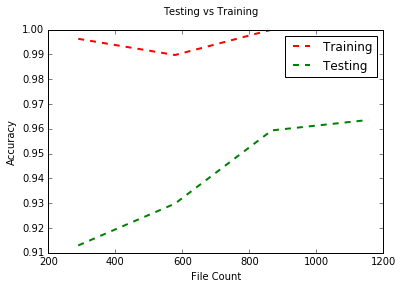

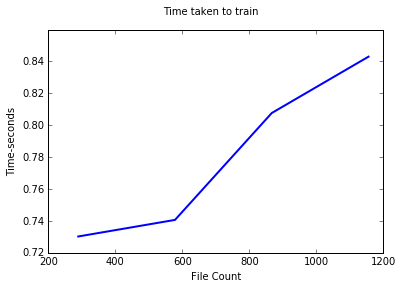

In [6]:
import matplotlib.pyplot as plt
# plot testing and training accuracy as the number of files increases
plt.figure(1)
plt.suptitle('Testing vs Training')
plt.xlabel('File Count')
plt.ylabel('Accuracy')
plt.plot(file_count, training_accuracy, 'r--', linewidth=2.0, label='Training')
plt.plot(file_count,testing_accuracy, 'g--',linewidth=2.0, label='Testing')
plt.legend(loc='upper right')
plt.show()

# plot time taken to train with the increase of file count
plt.figure(1)
plt.suptitle('Time taken to train')
plt.xlabel('File Count')
plt.ylabel('Time-seconds')
plt.plot(file_count, training_time, 'b-',linewidth=2.0)
plt.show()



#### Analysis of training and testing results

##### One can observe that Iterative algorithms are inefficient in standard MapReduce as it takes too much time to run, since intermediate resutlts will be written and read from/to disk which makes this processing very time consuming. As oppopsed to running machine learning algorithms in a normal python kernel does not take time since it does have to write/read from/to disk.

##### We used logistic regression to classify spam-ham messages. For preprocessing, we first implemented a tokenizer to break down the sentences into words, we also removed the stop words and punctuations to help increase the classification accuracy, then we used hashing to transform the tokens into fixed size TF vectors. After that, a grid search was implemented with varying hash size vector [10,100,200] since as the hash vector size increases the accuracy should increase too. Also ranged the regularization [0,0.1] to experiment with different regularization to avoid overfitting (unfortunately we could not increase the number of parameters in the grid search  because it takes too much time to run). The grid builder will then pick the best model (with the best parameters). However, we do not know what parameters produced the best results. The model was then evaluated on a hold out test set (unseen examples). 

##### The model was trained on 4 subdirectories only, with varying train set size. In the first run, the model was trained on first train set (part 1 with 289 files). Train accuracy was 99.6%, and took 0.73 seconds to train. This shows that the model is overfitting where it was able to correctly classify all the file almost 100%. It could also mean that the file may have uneven distribution of data or similar cases. As for the test accuracy, the result was 91%. It shows that, although the training model was overfitting, it is very well generalised on unseen examples and the grid builder was able to choose the best optimised model. And it could also mean that the file had a more balanced/unbiased data distribution.

##### The second training set comprises the first and the second parts together. The model was trained on 578 files and produced accuray of 98.9% (almost similar to the first trained model). The time taken to train was 0.74 second as opposed to 0.73 in the first trained model - computational time increases (though just by 0.1 seconds). Testing this model on the test set, resulted in an accuracy of ~93% (+2% increase from the first model). This shows that with more training data, the time taken to train increases and it improves the accuracy on the test set - produce a better model (generalised model). 

##### The third model was trained on 3 parts [1,2, and 3] which contain 867 files. The accuracy is 100% which is the ultimate case of overfitting and the time taken to train increased again from 0.74 second (in the second model) to 0.8 seconds. When testing this model on the test set, it produced ~96% (+5% increase compared to the first model and + 3% compared to the third model). Again, more training examples resulted in a better model when tested on the hold out test set and the computational time kept on increasing.

##### The fourth and final model, was built on all 4 parts [1-4] with 1156 files. The training accuracy was 100%, and took 0.84 seconds to train (+0.11 seconds increase compared to the first trained model). The model produced slightly better results on the test set with 96.3% accuracy (+~0.03 from the last model). Based on this experiement, we expect that as the training data increases, the computational time will increase and the accuracy on the test set will increase (slightly after this model since the accuracy is very high already) until it stabalises. 

##### The figures above help depict this experiment. The first figure (top) shows that the training accuracy varied between 99% to 100% (with varying training set size). And the test accuracy is always increasing when we increase the training data set. This means that more training data resutls in a well generalised model. We also expect to get even better results when the hash vector size increases. The  second figure (bottom) shows that the model takes more time to train when the training data increases.